**Initial step:** Please try to put the extracted CamVid folder in your Google Drive!
So now you could mount your data to this ipynb!

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# if you mount Google drive correctly, the following commands should be able to executed correctly
# !ls /content/drive/
# %cd "/content/drive/My Drive"
# %cd "CamVid"

# !ls

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
import random

from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import os
from os import path

from PIL import Image
import pandas as pd
from torchvision.models.vgg import VGG




In [4]:
device = torch.device("cuda:0")

In [5]:

# root_dir   = "/content/drive/My Drive/CamVid/"
root_dir   = "CamVid/"
train_file = os.path.join(root_dir, "train.csv")
val_file   = os.path.join(root_dir, "val.csv")

print("training csv exits:{}".format(path.exists(train_file)))
print("validation csv exits:{}".format(path.exists(val_file)))

# the folder to save results for comparison
# folder_to_save_validation_result = '/content/drive/My Drive/CamVid/result_comparision/' 
folder_to_save_validation_result = 'CamVid/result_comparision/'

if os.path.isdir(folder_to_save_validation_result) == False:
    os.mkdir(folder_to_save_validation_result)


# the number of segmentation classes
num_class = 12 # 32 for original CamVid
# num_class = 3
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR

h, w      = 256, 256
train_h = 256
train_w = 256
val_h = 256
val_w = 256

## parameters for Solver-Adam in this example
batch_size = 6 #
epochs     = 20 # don't try to improve the performance by simply increasing the training epochs or iterations
lr         = 1e-4    # achieved besty results 
step_size  = 100 # Won't work when epochs <=100
gamma      = 0.5 # 
#

## index for validation images
global_index = 0

# pixel accuracy and mIOU list 
pixel_acc_list = []
mIOU_list = []

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

class CamVidDataset(Dataset):

    def __init__(self, csv_file, phase, n_class=num_class, crop=True, flip_rate=0.5):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate       

        self.resize_h = h
        self.resize_w = w        
        
        if phase == 'train':
            self.new_h = train_h
            self.new_w = train_w
            self.crop = crop
        elif phase == 'val':
            self.flip_rate = 0.
            self.crop = False # False
            self.new_h = val_h
            self.new_w = val_w


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]                
        img_name = root_dir  + img_name                        
        img = Image.open(img_name).convert('RGB')  

        label_name = self.data.iloc[idx, 1]        
        label_name = root_dir  + label_name                       
        label_image = Image.open(label_name)
        label = np.asarray(label_image)

        # In training mode, the crop strategy is random-shift crop.
        # In validation model, it is center crop.
        if self.crop:            
            w, h = img.size
            A_x_offset = np.int32(np.random.randint(0, w - self.new_w + 1, 1))[0]
            A_y_offset = np.int32(np.random.randint(0, h - self.new_h + 1, 1))[0]

            img = img.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom
            label_image = label_image.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom
        else:            
            w, h = img.size
            A_x_offset = int((w - self.new_w)/2)
            A_y_offset = int((h - self.new_h)/2)
            
            img = img.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom
            label_image = label_image.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom

            label_image_h, label_image_w = label_image.size

        # we could try to revise the values in label for reducing the number of segmentation classes
        label = np.array(label_image)              

        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)
        
        # reduce mean in terms of BGR
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        if self.n_class == 12:
            # For 11 classes
            for c in range(self.n_class):
                target[c][label == c] = 1
        
        elif self.n_class == 3:
            # For 3 classes
            for c in range(11):
                if c == 0:
                    target[0][label == c] = 1
                elif 0 < c and c < 8:
                    target[1][label == c] = 1
                    label[label == c] = 1
                else:
                    target[2][label == c] = 1
                    label[label == c] = 2
            # Put void into class '1'
            target[1][label == 11] = 1
            label[label == 11] = 1
            
        sample = {'X': img, 'Y': target, 'l': label}

        return sample


train_data = CamVidDataset(csv_file=train_file, phase='train')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)

val_data = CamVidDataset(csv_file=val_file, phase='val', flip_rate=0)
val_loader = DataLoader(val_data, batch_size=1, num_workers=8)



training csv exits:True
validation csv exits:True


In [6]:
# a = train_data[0]['l']
# _all = 0
# for i in range(12):
#     print(len(a[a == i]))
#     _all+=len(a[a == i])
# print(_all)

In [7]:
# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg19', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:            
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output

class FCN8s(nn.Module):
    #Ref: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
    #The layer description is accordance with the above fiture instead of the original paper. Alex 2019/12/03 
    def __init__(self, pretrained_net, n_class, skip_con=True):
        super().__init__()
        self.n_class = n_class
        self.skip_con = skip_con
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        
        if self.skip_con == True:
            score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
            score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)                      
            score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
            score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)           
            score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
            score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
            score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
            score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

            return score  # size=(N, n_class, x.H/1, x.W/1)
        
        else:
            score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
            score = self.bn1(score)                           # size=(N, 512, x.H/16, x.W/16)                      
            score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
            score = self.bn2(score)                           # size=(N, 256, x.H/8, x.W/8)           
            score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
            score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
            score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
            score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
            
            return score  # size=(N, n_class, x.H/1, x.W/1)

# load pretrained weights and define FCN8s
vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN8s(pretrained_net=vgg_model, n_class=num_class, skip_con=True)

ts = time.time()
vgg_model = vgg_model.cuda()
fcn_model = fcn_model.cuda()
# fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  

Finish cuda loading, time elapsed 1.4418907165527344


In [8]:
def train():
    for epoch in range(epochs):
        scheduler.step()

        ts = time.time()
        for iter, batch in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        

        val(epoch)
        
    highest_pixel_acc = max(pixel_acc_list)
    highest_mIOU = max(mIOU_list)        
    
    highest_pixel_acc_epoch = pixel_acc_list.index(highest_pixel_acc)
    highest_mIOU_epoch = mIOU_list.index(highest_mIOU)
    
    print("The highest mIOU is {} and is achieved at epoch-{}".format(highest_mIOU, highest_mIOU_epoch))
    print("The highest pixel accuracy  is {} and is achieved at epoch-{}".format(highest_pixel_acc, highest_pixel_acc_epoch))
    




def save_result_comparison(input_np, output_np):
    means     = np.array([103.939, 116.779, 123.68]) / 255.
    
    global global_index
    
    original_im_RGB = np.zeros((256,256,3))    
    original_im_RGB[:,:,0] = input_np[0,0,:,:]    
    original_im_RGB[:,:,1] = input_np[0,1,:,:]
    original_im_RGB[:,:,2] = input_np[0,2,:,:]
        
    original_im_RGB[:,:,0] = original_im_RGB[:,:,0] + means[0]
    original_im_RGB[:,:,1] = original_im_RGB[:,:,1] + means[1]
    original_im_RGB[:,:,2] = original_im_RGB[:,:,2] + means[2]
        
    original_im_RGB[:,:,0] = original_im_RGB[:,:,0]*255.0
    original_im_RGB[:,:,1] = original_im_RGB[:,:,1]*255.0
    original_im_RGB[:,:,2] = original_im_RGB[:,:,2]*255.0
    
    im_seg_RGB = np.zeros((256,256,3))

    # the following version is designed for 11-class version and could still work if the number of classes is fewer.
    for i in range(256):
        for j in range(256):
            if output_np[i,j] == 0:                   # Sky
                im_seg_RGB[i,j,:] = [128, 128, 128]     # Grey
            elif output_np[i,j] == 1:                 # Building
                im_seg_RGB[i,j,:] = [128, 0, 0]         # Dark red
            elif output_np[i,j] == 2:                 # Pole
                im_seg_RGB[i,j,:] = [192, 192, 128]     # Light green yellow
            elif output_np[i,j] == 3:                 # Road
                im_seg_RGB[i,j,:] = [128, 64, 128]      # Dark purple
            elif output_np[i,j] == 4:                 # Pavement
                im_seg_RGB[i,j,:] = [0, 0, 192]         # Blue
            elif output_np[i,j] == 5:                 # Tree
                im_seg_RGB[i,j,:] = [128, 128, 0]       # Dark green yellow
            elif output_np[i,j] == 6:                 # Sign Symbol
                im_seg_RGB[i,j,:] = [192, 128, 128]     # Light red
            elif output_np[i,j] == 7:                 # Fence
                im_seg_RGB[i,j,:] = [64, 64, 128]       # Dark blue
            elif output_np[i,j] == 8:                 # Car
                im_seg_RGB[i,j,:] = [64, 0, 128]        # Purple
            elif output_np[i,j] == 9:                 # Pedestrian
                im_seg_RGB[i,j,:] = [64, 64, 0]         # Dark green
            elif output_np[i,j] == 10:                # Bicyclist
                im_seg_RGB[i,j,:] = [0, 128, 192]       # Light blue
            else:                                     # Void
                im_seg_RGB[i,j,:] = [0, 0, 0]           # Black
                    
    # horizontally stack original image and its corresponding segmentation results     
    hstack_image = np.hstack((original_im_RGB, im_seg_RGB))             
    new_im = Image.fromarray(np.uint8(hstack_image))
    
    file_name = folder_to_save_validation_result + str(global_index) + '.jpg'
        
    global_index = global_index + 1
        
    new_im.save(file_name)       
    display(new_im)

---------iter=0


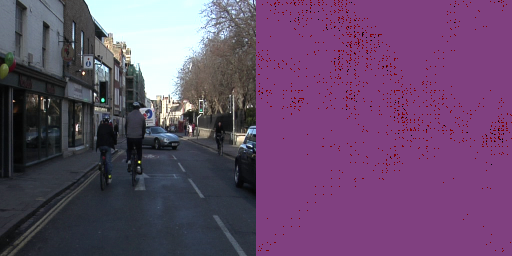

epoch0, pix_acc: 0.3262786865234375, meanIoU: 0.030900342864550654, IoUs: [0.         0.04468325 0.         0.32326624 0.         0.
 0.         0.         0.         0.         0.         0.00285463]
epoch0, iter0, loss: 0.6844170689582825
epoch0, iter10, loss: 0.681611180305481
epoch0, iter20, loss: 0.6561214923858643
epoch0, iter30, loss: 0.587520182132721
epoch0, iter40, loss: 0.5400999188423157
epoch0, iter50, loss: 0.47950735688209534
epoch0, iter60, loss: 0.4275246858596802
Finish epoch 0, time elapsed 10.215845584869385
---------iter=0


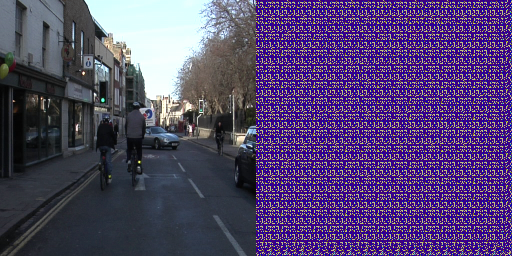

epoch0, pix_acc: 0.02635101318359375, meanIoU: 0.009332531209221739, IoUs: [0.00463481 0.         0.00643109 0.00054192 0.04474849 0.01747978
 0.00026735 0.01871376 0.01906621 0.         0.00010698 0.        ]
epoch1, iter0, loss: 0.40992316603660583
epoch1, iter10, loss: 0.4281315207481384
epoch1, iter20, loss: 0.33394792675971985
epoch1, iter30, loss: 0.32233473658561707
epoch1, iter40, loss: 0.3278959095478058
epoch1, iter50, loss: 0.279915988445282
epoch1, iter60, loss: 0.27187052369117737
Finish epoch 1, time elapsed 10.262725353240967
---------iter=0


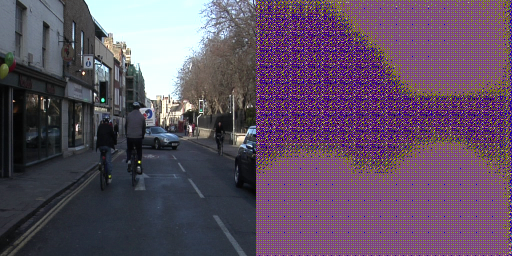

epoch1, pix_acc: 0.28228408813476563, meanIoU: 0.06371369474872657, IoUs: [1.19867473e-01 4.59604755e-03 7.17273915e-03 3.95139604e-01
 9.11621562e-03 1.19868364e-01 2.82031826e-02 3.66107690e-02
 3.95149294e-02 0.00000000e+00 7.70049690e-06 4.46731191e-03]
epoch2, iter0, loss: 0.2690940499305725
epoch2, iter10, loss: 0.22766749560832977
epoch2, iter20, loss: 0.2180001139640808
epoch2, iter30, loss: 0.16646631062030792
epoch2, iter40, loss: 0.16368883848190308
epoch2, iter50, loss: 0.17209574580192566
epoch2, iter60, loss: 0.19909130036830902
Finish epoch 2, time elapsed 10.278886556625366
---------iter=0


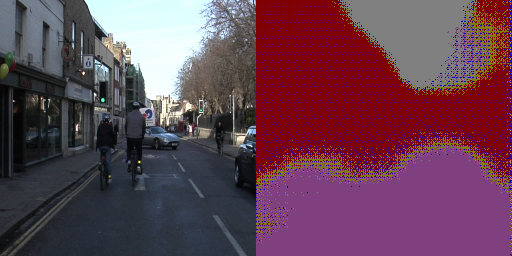

epoch2, pix_acc: 0.6086036682128906, meanIoU: 0.17770545807003713, IoUs: [7.40254484e-01 4.29187116e-01 0.00000000e+00 7.66532664e-01
 1.39327058e-02 1.40503066e-01 9.48569470e-04 1.67341532e-03
 3.93016628e-02 0.00000000e+00 4.51306749e-05 8.66828033e-05]
epoch3, iter0, loss: 0.15066778659820557
epoch3, iter10, loss: 0.13700397312641144
epoch3, iter20, loss: 0.15543729066848755
epoch3, iter30, loss: 0.18189175426959991
epoch3, iter40, loss: 0.13581667840480804
epoch3, iter50, loss: 0.13846658170223236
epoch3, iter60, loss: 0.18623915314674377
Finish epoch 3, time elapsed 10.431055068969727
---------iter=0


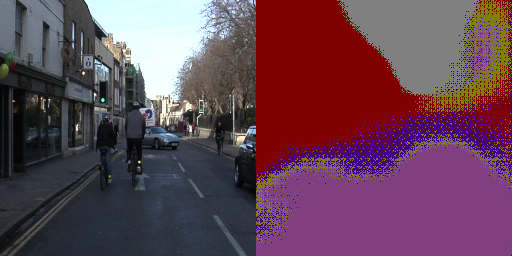

epoch3, pix_acc: 0.6813449096679688, meanIoU: 0.22315431024962842, IoUs: [7.77333303e-01 6.02395871e-01 0.00000000e+00 7.73164702e-01
 6.65505021e-03 4.23522844e-01 4.37004890e-05 0.00000000e+00
 9.31983425e-02 0.00000000e+00 0.00000000e+00 1.53790964e-03]
epoch4, iter0, loss: 0.14240947365760803
epoch4, iter10, loss: 0.11895637959241867
epoch4, iter20, loss: 0.13466627895832062
epoch4, iter30, loss: 0.11822867393493652
epoch4, iter40, loss: 0.15890762209892273
epoch4, iter50, loss: 0.10926739871501923
epoch4, iter60, loss: 0.12403146177530289
Finish epoch 4, time elapsed 10.300750017166138
---------iter=0


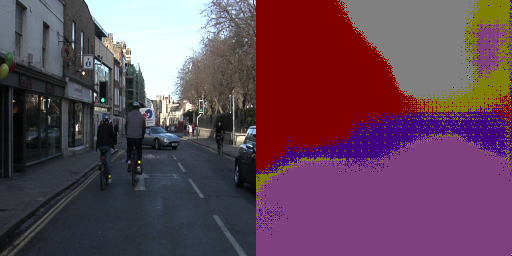

epoch4, pix_acc: 0.7112060546875, meanIoU: 0.23755769680989566, IoUs: [0.73015211 0.67929282 0.         0.77683629 0.00376021 0.5512062
 0.00080882 0.00129686 0.10543132 0.         0.         0.00190774]
epoch5, iter0, loss: 0.13169105350971222
epoch5, iter10, loss: 0.12018638104200363
epoch5, iter20, loss: 0.13902606070041656
epoch5, iter30, loss: 0.1232869103550911
epoch5, iter40, loss: 0.10936320573091507
epoch5, iter50, loss: 0.1074601486325264
epoch5, iter60, loss: 0.10651648044586182
Finish epoch 5, time elapsed 10.333934307098389
---------iter=0


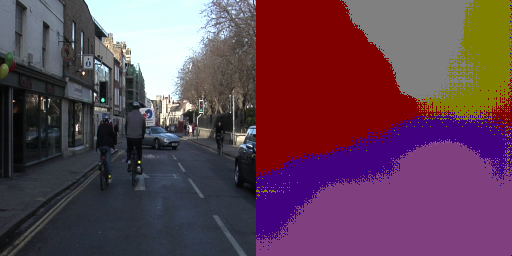

epoch5, pix_acc: 0.7278453063964844, meanIoU: 0.2612807610791539, IoUs: [8.19213448e-01 6.79011452e-01 0.00000000e+00 8.45390128e-01
 6.43475016e-03 6.87180378e-01 5.43478261e-05 7.52433387e-04
 9.46635072e-02 0.00000000e+00 0.00000000e+00 2.66868812e-03]
epoch6, iter0, loss: 0.12824828922748566
epoch6, iter10, loss: 0.09912734478712082
epoch6, iter20, loss: 0.10314573347568512
epoch6, iter30, loss: 0.093900665640831
epoch6, iter40, loss: 0.12448851019144058
epoch6, iter50, loss: 0.11500559747219086
epoch6, iter60, loss: 0.12721005082130432
Finish epoch 6, time elapsed 10.35228419303894
---------iter=0


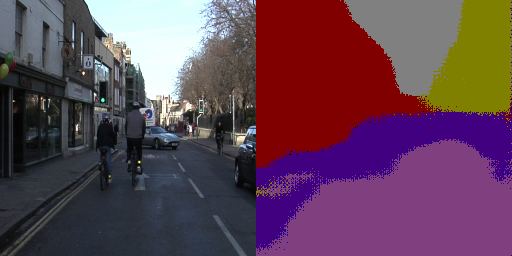

epoch6, pix_acc: 0.7380307006835938, meanIoU: 0.2786162304810624, IoUs: [0.8833209  0.71109482 0.         0.8241116  0.01280774 0.8116137
 0.         0.         0.09945839 0.         0.         0.00098761]
epoch7, iter0, loss: 0.15558606386184692
epoch7, iter10, loss: 0.08782383054494858
epoch7, iter20, loss: 0.09642349928617477
epoch7, iter30, loss: 0.08748391270637512
epoch7, iter40, loss: 0.09774498641490936
epoch7, iter50, loss: 0.09939462691545486
epoch7, iter60, loss: 0.10043733566999435
Finish epoch 7, time elapsed 10.466011762619019
---------iter=0


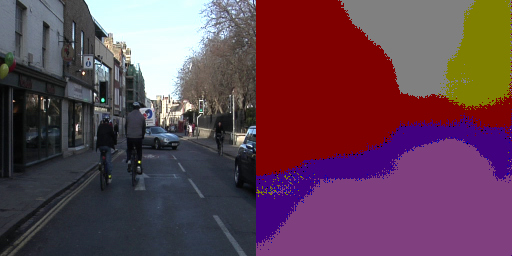

epoch7, pix_acc: 0.7535165405273437, meanIoU: 0.27420222892525165, IoUs: [8.56087353e-01 6.37111773e-01 7.84517987e-04 8.44098915e-01
 2.54473169e-02 7.90440817e-01 0.00000000e+00 0.00000000e+00
 1.24484714e-01 0.00000000e+00 0.00000000e+00 1.19713414e-02]
epoch8, iter0, loss: 0.11075465381145477
epoch8, iter10, loss: 0.06433384865522385
epoch8, iter20, loss: 0.1074468269944191
epoch8, iter30, loss: 0.07717137783765793
epoch8, iter40, loss: 0.10845544189214706
epoch8, iter50, loss: 0.09674143046140671
epoch8, iter60, loss: 0.08320387452840805
Finish epoch 8, time elapsed 10.354220628738403
---------iter=0


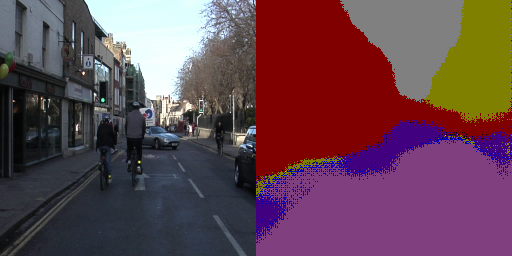

epoch8, pix_acc: 0.7746060180664063, meanIoU: 0.2887608262809162, IoUs: [0.88364022 0.6921489  0.00166888 0.82637139 0.10181919 0.74101138
 0.         0.         0.20258896 0.         0.         0.015881  ]
epoch9, iter0, loss: 0.08938296884298325
epoch9, iter10, loss: 0.08881431072950363
epoch9, iter20, loss: 0.11139991879463196
epoch9, iter30, loss: 0.09973074495792389
epoch9, iter40, loss: 0.08622990548610687
epoch9, iter50, loss: 0.08951675891876221
epoch9, iter60, loss: 0.10785035043954849
Finish epoch 9, time elapsed 10.371687412261963
---------iter=0


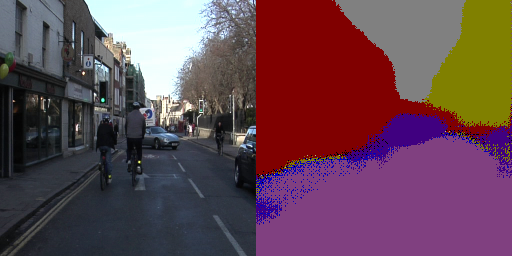

epoch9, pix_acc: 0.7752333068847657, meanIoU: 0.29076256187991856, IoUs: [0.8831668  0.70152715 0.00270731 0.80237769 0.07966852 0.7433028
 0.         0.         0.25451988 0.         0.         0.02188059]
epoch10, iter0, loss: 0.10468409955501556
epoch10, iter10, loss: 0.09340156614780426
epoch10, iter20, loss: 0.09234169870615005
epoch10, iter30, loss: 0.08232289552688599
epoch10, iter40, loss: 0.10986166447401047
epoch10, iter50, loss: 0.07906904816627502
epoch10, iter60, loss: 0.11103599518537521
Finish epoch 10, time elapsed 10.468237400054932
---------iter=0


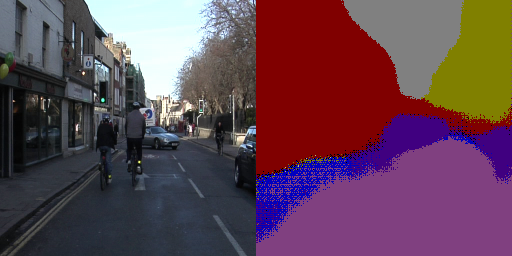

epoch10, pix_acc: 0.7880087280273438, meanIoU: 0.3141774788320714, IoUs: [0.90035377 0.69836591 0.0016838  0.84206692 0.27232649 0.77284132
 0.         0.         0.25621712 0.         0.         0.0262744 ]
epoch11, iter0, loss: 0.09484030306339264
epoch11, iter10, loss: 0.08269510418176651
epoch11, iter20, loss: 0.0922919437289238
epoch11, iter30, loss: 0.09437502920627594
epoch11, iter40, loss: 0.07893260568380356
epoch11, iter50, loss: 0.08649030327796936
epoch11, iter60, loss: 0.07060406357049942
Finish epoch 11, time elapsed 10.462530136108398
---------iter=0


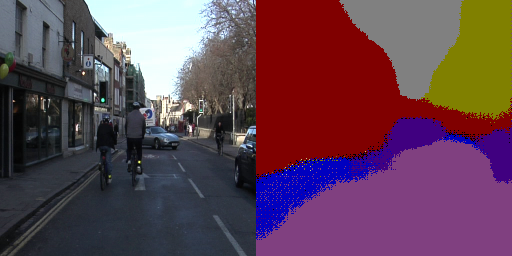

epoch11, pix_acc: 0.8086363220214844, meanIoU: 0.3363421372220681, IoUs: [0.89803921 0.67687683 0.00178332 0.87035253 0.44191298 0.82863029
 0.         0.         0.28483389 0.         0.         0.03367659]
epoch12, iter0, loss: 0.07368879020214081
epoch12, iter10, loss: 0.06225156784057617
epoch12, iter20, loss: 0.07665298879146576
epoch12, iter30, loss: 0.0629892349243164
epoch12, iter40, loss: 0.08990661054849625
epoch12, iter50, loss: 0.08937273919582367
epoch12, iter60, loss: 0.10702110826969147
Finish epoch 12, time elapsed 10.464076519012451
---------iter=0


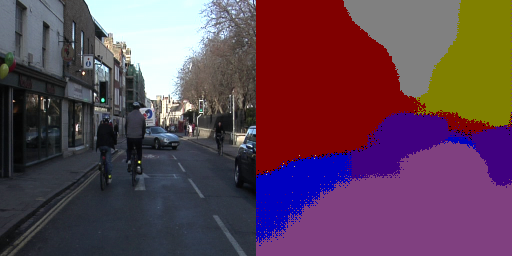

epoch12, pix_acc: 0.7942774963378906, meanIoU: 0.3383692409673495, IoUs: [8.90461176e-01 6.99798546e-01 6.73962732e-04 8.59202092e-01
 5.92526140e-01 7.85771885e-01 0.00000000e+00 0.00000000e+00
 2.07013951e-01 0.00000000e+00 0.00000000e+00 2.49831388e-02]
epoch13, iter0, loss: 0.08304797112941742
epoch13, iter10, loss: 0.08294323086738586
epoch13, iter20, loss: 0.06618944555521011
epoch13, iter30, loss: 0.07643939554691315
epoch13, iter40, loss: 0.06722574681043625
epoch13, iter50, loss: 0.10025550425052643
epoch13, iter60, loss: 0.0884561762213707
Finish epoch 13, time elapsed 10.393794536590576
---------iter=0


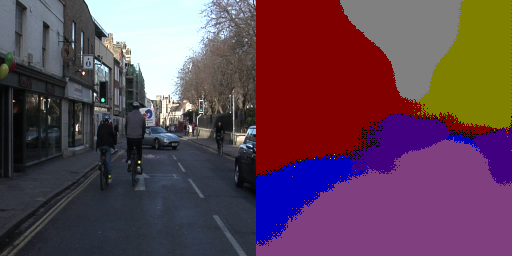

epoch13, pix_acc: 0.8086019897460938, meanIoU: 0.34704885893619714, IoUs: [8.88825781e-01 7.12412757e-01 4.15340602e-04 8.93017253e-01
 6.45559054e-01 7.31328148e-01 0.00000000e+00 0.00000000e+00
 2.49954081e-01 0.00000000e+00 0.00000000e+00 4.30738924e-02]
epoch14, iter0, loss: 0.07877954095602036
epoch14, iter10, loss: 0.07807738333940506
epoch14, iter20, loss: 0.07827873528003693
epoch14, iter30, loss: 0.06662527471780777
epoch14, iter40, loss: 0.06899581849575043
epoch14, iter50, loss: 0.08752401173114777
epoch14, iter60, loss: 0.08466219902038574
Finish epoch 14, time elapsed 10.502113103866577
---------iter=0


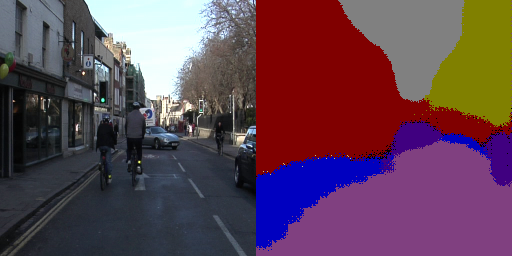

epoch14, pix_acc: 0.8123272705078125, meanIoU: 0.35190735574291243, IoUs: [8.94081629e-01 6.53542017e-01 8.30571548e-04 8.76084848e-01
 5.58541547e-01 8.03721946e-01 0.00000000e+00 0.00000000e+00
 4.06855030e-01 1.22672679e-04 0.00000000e+00 2.91080068e-02]
epoch15, iter0, loss: 0.07717489451169968
epoch15, iter10, loss: 0.09205325692892075
epoch15, iter20, loss: 0.0695352703332901
epoch15, iter30, loss: 0.05803434178233147
epoch15, iter40, loss: 0.09513044357299805
epoch15, iter50, loss: 0.06739422678947449
epoch15, iter60, loss: 0.0615793876349926
Finish epoch 15, time elapsed 10.49449372291565
---------iter=0


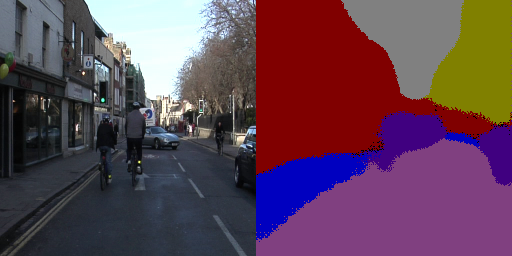

epoch15, pix_acc: 0.8245236206054688, meanIoU: 0.3587028922510616, IoUs: [9.06326801e-01 6.89573726e-01 6.02912487e-04 9.13304762e-01
 6.70428087e-01 8.25231300e-01 0.00000000e+00 0.00000000e+00
 2.75817770e-01 3.56529640e-05 0.00000000e+00 2.31136955e-02]
epoch16, iter0, loss: 0.0748797133564949
epoch16, iter10, loss: 0.04962678626179695
epoch16, iter20, loss: 0.06782298535108566
epoch16, iter30, loss: 0.06173492968082428
epoch16, iter40, loss: 0.08138789236545563
epoch16, iter50, loss: 0.07935484498739243
epoch16, iter60, loss: 0.06759973615407944
Finish epoch 16, time elapsed 10.38310170173645
---------iter=0


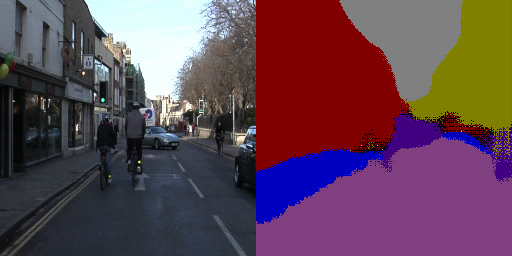

epoch16, pix_acc: 0.8141123962402343, meanIoU: 0.3526702128649326, IoUs: [8.92789116e-01 6.91484312e-01 2.44498778e-05 8.97645970e-01
 5.38912024e-01 7.10231437e-01 0.00000000e+00 0.00000000e+00
 3.95050910e-01 0.00000000e+00 0.00000000e+00 1.05904335e-01]
epoch17, iter0, loss: 0.07987304776906967
epoch17, iter10, loss: 0.08551301062107086
epoch17, iter20, loss: 0.08776366710662842
epoch17, iter30, loss: 0.05930890142917633
epoch17, iter40, loss: 0.07555238157510757
epoch17, iter50, loss: 0.04859161749482155
epoch17, iter60, loss: 0.08524761348962784
Finish epoch 17, time elapsed 10.390642166137695
---------iter=0


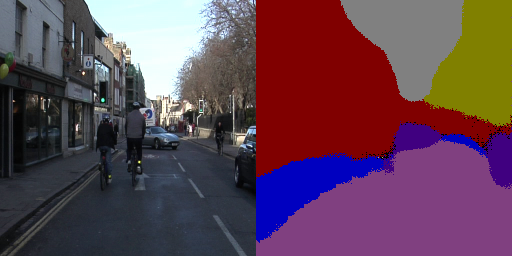

epoch17, pix_acc: 0.8282022094726562, meanIoU: 0.36555979615257367, IoUs: [8.96845351e-01 6.64748984e-01 0.00000000e+00 9.13880645e-01
 6.46449800e-01 8.11897079e-01 0.00000000e+00 0.00000000e+00
 4.12750724e-01 6.11560277e-05 0.00000000e+00 4.00838155e-02]
epoch18, iter0, loss: 0.08141161501407623
epoch18, iter10, loss: 0.0524095855653286
epoch18, iter20, loss: 0.057556603103876114
epoch18, iter30, loss: 0.06266923248767853
epoch18, iter40, loss: 0.0890236645936966
epoch18, iter50, loss: 0.06576564908027649
epoch18, iter60, loss: 0.08395158499479294
Finish epoch 18, time elapsed 10.48508620262146
---------iter=0


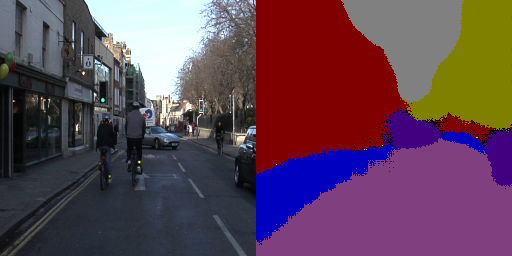

epoch18, pix_acc: 0.8181327819824219, meanIoU: 0.35935729229363683, IoUs: [8.98008396e-01 6.95094714e-01 7.84648627e-04 9.04037015e-01
 5.71651731e-01 7.53966745e-01 0.00000000e+00 0.00000000e+00
 3.91253150e-01 2.78819649e-04 0.00000000e+00 9.72122873e-02]
epoch19, iter0, loss: 0.05897721275687218
epoch19, iter10, loss: 0.05700094252824783
epoch19, iter20, loss: 0.06532593816518784
epoch19, iter30, loss: 0.06762107461690903
epoch19, iter40, loss: 0.07395350933074951
epoch19, iter50, loss: 0.09140118211507797
epoch19, iter60, loss: 0.0674271434545517
Finish epoch 19, time elapsed 10.419398307800293
---------iter=0


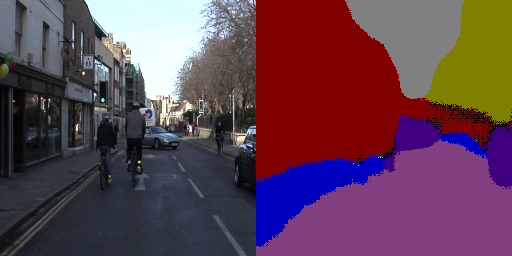

epoch19, pix_acc: 0.8077293395996094, meanIoU: 0.358601256532532, IoUs: [9.03893575e-01 6.43281997e-01 6.25000000e-05 8.65531308e-01
 5.35882037e-01 8.53637089e-01 0.00000000e+00 1.36132830e-05
 4.26809484e-01 0.00000000e+00 2.69964554e-06 7.41007758e-02]
The highest mIOU is 0.36555979615257367 and is achieved at epoch-18
The highest pixel accuracy  is 0.8282022094726562 and is achieved at epoch-18


In [9]:
def val(epoch):
    fcn_model.eval()
    total_ious = []
    pixel_accs = []
                    
    
    for iter, batch in enumerate(val_loader): ## batch is 1 in this case
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])        

        output = fcn_model(inputs)                                
        
        # only save the 1st image for comparison
        if iter == 0:
            print('---------iter={}'.format(iter))
            # generate images
            images = output.data.max(1)[1].cpu().numpy()[:,:,:]
            image = images[0,:,:]        
            save_result_comparison(batch['X'], image)
                            
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape                
        pred = output.transpose(0, 2, 3, 1).reshape(-1, num_class).argmax(axis=1).reshape(N, h, w)        
        target = batch['l'].cpu().numpy().reshape(N, h, w)

        for p, t in zip(pred, target):
            total_ious.append(iou(p, t))
            pixel_accs.append(pixel_acc(p, t))

    # Calculate average IoU
    total_ious = np.array(total_ious).T  # n_class * val_len
    ious = np.nanmean(total_ious, axis=1)
    pixel_accs = np.array(pixel_accs).mean()
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}".format(epoch, pixel_accs, np.nanmean(ious), ious))
    
    global pixel_acc_list
    global mIOU_list
    
    pixel_acc_list.append(pixel_accs)
    mIOU_list.append(np.nanmean(ious))


# borrow functions and modify it from https://github.com/Kaixhin/FCN-semantic-segmentation/blob/master/main.py
# Calculates class intersections over unions
def iou(pred, target):
    ious = []
    for cls in range(num_class):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
        # print("cls", cls, pred_inds.sum(), target_inds.sum(), intersection, float(intersection) / max(union, 1))
    return ious


def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total


## perform training and validation
val(0)  # show the accuracy before training
train()

VGG16

In [10]:
# 11 classes
# With Skip Connection
# The highest mIOU is 0.38351497151564085 and is achieved at epoch-19
# The highest pixel accuracy  is 0.8240522766113281 and is achieved at epoch-16

In [11]:
# 11 classes
# Without Skip Connection
# The highest mIOU is 0.36997329484134645 and is achieved at epoch-20
# The highest pixel accuracy  is 0.8068479919433593 and is achieved at epoch-19

In [12]:
# 3 classes
# With Skip Connection
# The highest mIOU is 0.8288663694937249 and is achieved at epoch-19
# The highest pixel accuracy  is 0.94724853515625 and is achieved at epoch-19

In [13]:
# 3 classes
# Without Skip Connection
# The highest mIOU is 0.793770031284938 and is achieved at epoch-20
# The highest pixel accuracy  is 0.9362069702148438 and is achieved at epoch-20

VGG19

In [14]:
# 3 classes
# With Skip Connection
# The highest mIOU is 0.851145283862908 and is achieved at epoch-20
# The highest pixel accuracy  is 0.9684840393066406 and is achieved at epoch-20

In [15]:
# 11 classes
# With Skip Connection
# The highest mIOU is 0.395396671334664 and is achieved at epoch-17
# The highest pixel accuracy  is 0.8306016540527343 and is achieved at epoch-17